In [5]:
import tensorflow as tf
import bunch
import os
import json
import pickle
import numpy as np
import pandas

from model import HyperModel
from vocab import Vocab
from dataset import Dataset

In [6]:
expdir = 'exps/ctweet0'
datafile = '/g/ssli/data/LowResourceLM/tweets/train.tsv.gz'
datafile = '/s0/ajaech/codeswitchtmp.csv.gz'

In [7]:
filename = '/g/ssli/data/langid/gideon/spanish.csv'
spanish = pandas.read_csv(filename, header=None)
spanish.columns = ['text']
spanish['lang'] = 'en'
spanish = spanish[['lang', 'text']]
spanish['text'] = spanish['text'].apply(lambda x: x.replace('\n', ' '))
spanish.head()
spanish.to_csv('/s0/ajaech/codeswitchtmp.csv', sep='\t', header=None, index=None)

In [8]:
param_filename = os.path.join(expdir, 'params.json')
with open(param_filename, 'r') as f:
    params = bunch.Bunch(json.load(f))

In [9]:
dataset = Dataset(max_len=params.max_len + 1,
                  preshuffle=False,
                  batch_size=10)
dataset.ReadData(datafile, params.context_vars + ['text'],
               mode='all', splitter=params.splitter, limit=100)


loaded 100 sentences


In [10]:
vocab = Vocab.Load(os.path.join(expdir, 'word_vocab.pickle'))
with open(os.path.join(expdir, 'context_vocab.pickle'), 'rb') as f:
    context_vocabs = pickle.load(f)

In [11]:
unigram_probs = vocab.GetUnigramProbs()
params.batch_size = 10
use_nce_loss = False
tf.reset_default_graph()
model = HyperModel(
  params, unigram_probs,
  [len(context_vocabs[v]) for v in params.context_vars],
  use_nce_loss=use_nce_loss)


In [12]:
saver = tf.train.Saver(tf.all_variables())
session = tf.Session()

def GetFeedDict(batch, use_dropout=True):
  s = np.array(list(batch.text.values))  # hacky                                                                           
  feed_dict = {
    model.word_ids: s,
    model.seq_len: batch.seq_lens.values,
    model.dropout_keep_prob: params.dropout_keep_prob
  }

  if hasattr(model, 'context_placeholders'):
    for context_var in params.context_vars:
      placeholder = model.context_placeholders[context_var]
      feed_dict[placeholder] = batch[context_var].values

  if not use_dropout:
    del feed_dict[model.dropout_keep_prob]

  return feed_dict


In [13]:
dataset.Prepare(vocab, context_vocabs)
num_batches = dataset.GetNumBatches()


In [14]:
print 'loading model'
saver.restore(session, os.path.join(expdir, 'model.bin'))

loading model


In [15]:
features = []
labels = []
for _ in xrange(min(dataset.GetNumBatches(), 200)):
    batch = dataset.GetNextBatch()
    feed_dict = GetFeedDict(batch, use_dropout=False)
    a = session.run(model.zz, feed_dict)
    features.append(a.c)
    labels.append(batch.lang)

In [16]:
all_features2 = np.vstack(features)
all_labels2 = np.hstack(labels)

In [17]:
all_features.shape, all_labels.shape, all_features2.shape, all_labels2.shape

NameError: name 'all_features' is not defined

In [18]:
from matplotlib import pyplot

In [19]:
from sklearn import linear_model
logreg = linear_model.LogisticRegression(C=0.1, penalty='l1')

In [364]:
logreg.fit(all_features2, all_labels2)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [365]:
(logreg.predict(all_features) == all_labels).sum() 

12208

In [366]:
12669.0 / len(all_labels)

0.9049285714285714

In [367]:
12901.0 / len(all_labels)

0.9215

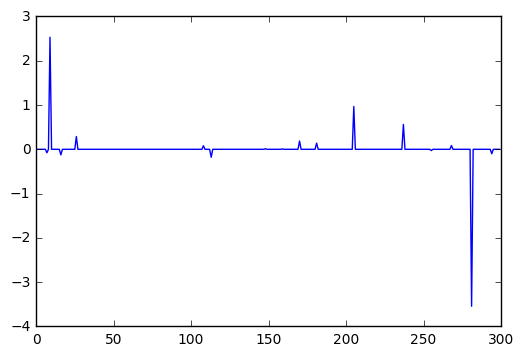

In [484]:
pyplot.plot(logreg.coef_.T[:, 2])
pyplot.show()

In [482]:
context_vocabs['lang'][3]

'es'

In [393]:
from metrics import Metrics

In [394]:
Metrics(list(logreg.predict(all_features)), list(all_labels));

accuracy = 0.872
 Lang     Prec.   Rec.   F1
------------------------------
       0   61.62  46.55  53.03
       1   66.67   4.10   7.73
       2   91.04  97.55  94.18
       3   86.81  94.48  90.48
       4   95.97  68.39  79.87
       5   61.39  40.51  48.81
       6    0.00   0.00   0.00
       7    0.00   0.00   0.00
       8   88.16  95.25  91.57
------------------------------
  Total:   61.29  49.65  51.74


In [617]:
batch = dataset.GetNextBatch()
feed_dict = GetFeedDict(batch, use_dropout=False)
a = session.run(model.outputs, feed_dict)

In [618]:
batch

,lang,text,seq_lens
60,2,"[32, 72, 84, 75, 75, 74, 74, 15, 78, 88, 15, 7...",63
61,2,"[32, 56, 74, 76, 90, 78, 82, 84, 88, 2, 72, 84...",99
62,2,"[32, 78, 75, 2, 82, 94, 2, 76, 78, 87, 81, 2, ...",40
63,2,"[32, 84, 71, 91, 78, 84, 84, 84, 84, 84, 14, 2...",48
64,2,"[32, 5, 2, 87, 74, 83, 90, 83, 72, 78, 70, 2, ...",17
65,2,"[32, 52, 2, 85, 70, 88, 88, 70, 73, 84, 2, 72,...",69
66,2,"[32, 38, 87, 74, 2, 94, 84, 90, 2, 87, 74, 70,...",86
67,2,"[32, 78, 76, 90, 70, 81, 2, 94, 84, 2, 89, 70,...",43
68,2,"[32, 57, 77, 74, 2, 92, 70, 81, 80, 78, 83, 76...",70
69,2,"[32, 84, 82, 76, 2, 88, 84, 94, 2, 89, 70, 83,...",118


In [619]:
np.argmax(logreg.coef_.T[:, 2]), np.argmin(logreg.coef_.T[:, 2])

(9, 281)

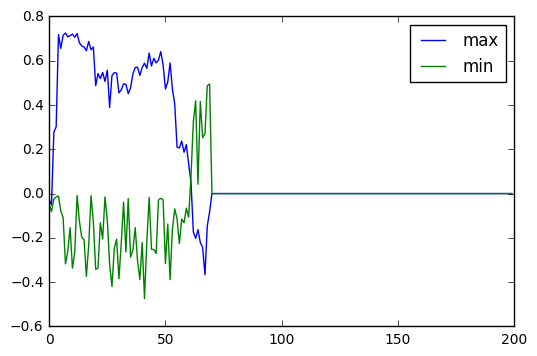

In [643]:
sample = 8
pyplot.plot(a[sample, :, 9])
pyplot.plot(a[sample, :, 281])
#pyplot.plot(logreg.predict_proba(a[sample, :, :]))
pyplot.legend(['max', 'min'])
pyplot.show()

In [644]:
''.join([vocab[q] for q in batch.text.iloc[sample]]).decode('utf8')

u'<S>The walking dead, Lost, Ouscast , breaking bad   mira alguna de esas</S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S></S>'

In [645]:
def rgb_to_hex(red, green, blue, _):
    """Return color as #rrggbb for the given color values."""
    return '#%02x%02x%02x' % (255 * red, 255 * green, 255 * blue)

In [646]:
min(scores), max(scores)

(-0.57142514, 0.39033422)

In [647]:
import matplotlib
phrase = [vocab[q] for q in batch.text.iloc[sample]]
scores = a[sample, :, 9]
cmap = pyplot.cm.spring
norm = matplotlib.colors.Normalize(vmin=min(scores), vmax=max(scores))
code=''
for char, score in zip(phrase, scores):
    color = cmap(norm(score))
    rgb = rgb_to_hex(*color)
    code += '<span style="background-color:{1}">{0}</span>'.format(char, rgb)
print code

<span style="background-color:#ff4fb0"><S></span><span style="background-color:#ff49b5">T</span><span style="background-color:#ff9669">h</span><span style="background-color:#ff9c62">e</span><span style="background-color:#fffe00"> </span><span style="background-color:#ffef10">w</span><span style="background-color:#fffd01">a</span><span style="background-color:#ffff00">l</span><span style="background-color:#fffb04">k</span><span style="background-color:#fffd01">i</span><span style="background-color:#fffe00">n</span><span style="background-color:#fffb04">g</span><span style="background-color:#ffff00"> </span><span style="background-color:#fff509">d</span><span style="background-color:#fff20d">e</span><span style="background-color:#fff10e">a</span><span style="background-color:#ffed11">d</span><span style="background-color:#fff708">,</span><span style="background-color:#ffee10"> </span><span style="background-color:#fff10e">L</span><span style="background-color:#ffc837">o</span><span style

In [146]:
df = pandas.read_csv('/g/ssli/data/LowResourceLM/tweets/train.tsv.gz', compression='gzip', sep='\t',
               header=None)
df.columns = ['lang', 'text']
df.head()

,lang,text
0,es,"Alemania vs Argentina, la tercera es la vencid..."
1,en,I have gained level 39 in The Tribez and Castl...
2,pt,"Finalmente é sexta, mas ainda tenho teste"
3,fr,#Marée ↗ #Mimizan 14/04/2016 UTC+2 Basse mer 1...
4,es,Que ganitas de poder ir al gym jupe..


In [224]:
samples = []
grps = df.groupby('lang')
for lang, g in grps:
    sample = g.sample(30)
    samples.append(sample)

In [225]:
selection = pandas.concat(samples)


In [226]:
selection.to_csv('/g/ssli/data/LowResourceLM/tweets/sample.tsv.gz', compression='gzip', sep='\t',
                header=None, index=None)

In [227]:
features.shape

AttributeError: 'list' object has no attribute 'shape'